# Introduction #

Once you've identified a set of features with some potential, it's time to start developing them. In this lesson, you'll learn a number of common transformations you can do entirely in Pandas. If you're feeling rusty, we've got a great [course on Pandas](https://www.kaggle.com/learn/pandas).

We'll use four datasets in this lesson having a range of feature types: [*US Traffic Accidents*](https://www.kaggle.com/sobhanmoosavi/us-accidents), [*1985 Automobiles*](https://www.kaggle.com/toramky/automobile-dataset), [*Concrete Formulations*](https://www.kaggle.com/sinamhd9/concrete-comprehensive-strength), and [*Customer Lifetime Value*](https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data). The following hidden cell loads them up.

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

accidents = pd.read_csv("../input/fe-course-data/accidents.csv")
autos = pd.read_csv("../input/fe-course-data/autos.csv")
concrete = pd.read_csv("../input/fe-course-data/concrete.csv")
customer = pd.read_csv("../input/fe-course-data/customer.csv")

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>Tips on Discovering New Features</strong>
<ul>
<li>Understand the features. Refer to your dataset's <em>data documentation</em>, if available.
<li>Research the problem domain to acquire <strong>domain knowledge</strong>. If your problem is predicting house prices, do some research on real-estate for instance. Wikipedia can be a good starting point, but books and <a href="https://scholar.google.com/">journal articles</a> will often have the best information.
<li>Study previous work. <a href="https://www.kaggle.com/sudalairajkumar/winning-solutions-of-kaggle-competitions">Solution write-ups</a> from past Kaggle competitions are a great resource.
<li>Use data visualization. Visualization can reveal pathologies in the distribution of a feature or complicated relationships that could be simplified. Be sure to visualize your dataset as you work through the feature engineering process.
<ul>
</blockquote>

# Mathematical Transforms #

Relationships among numerical features are often expressed through mathematical formulas, which you'll frequently come across as part of your domain research. In Pandas, you can apply arithmetic operations to columns just as if they were ordinary numbers.

In the *Automobile* dataset are features describing a car's engine. Research yields a variety of formulas for creating potentially useful new features. The "stroke ratio", for instance, is a measure of how efficient an engine is versus how performant:

In [2]:
autos["stroke_ratio"] = autos.stroke / autos.bore

autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


The more complicated a combination is, the more difficult it will be for a model to learn, like this formula for an engine's "displacement", a measure of its power:

In [3]:
autos["displacement"] = (
    np.pi * ((0.5 * autos.bore) ** 2) * autos.stroke * autos.num_of_cylinders
)

Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms. The distribution of `WindSpeed` in *US Accidents* is highly skewed, for instance. In this case the logarithm is effective at normalizing it:

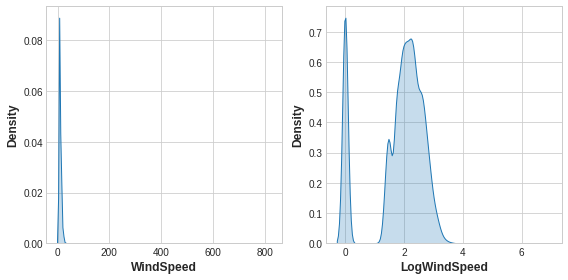

In [4]:
# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1]);

Check out our [lesson on normalization](https://www.kaggle.com/alexisbcook/scaling-and-normalization) in [*Data Cleaning*](https://www.kaggle.com/learn/data-cleaning) where you'll also learn about the *Box-Cox transformation*, a very general kind of normalizer.

# Counts #

Features describing the presence or absence of something often come in sets, the set of risk factors for a disease, say. You can aggregate such features by creating a **count**.

These features will be *binary* (`1` for Present, `0` for Absent) or *boolean* (`True` or `False`). In Python, booleans can be added up just as if they were integers.

In *Traffic Accidents* are several features indicating whether some roadway object was near the accident. This will create a count of the total number of roadway features nearby using the `sum` method:

In [5]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


You could also use a dataframe's built-in methods to *create* boolean values. In the *Concrete* dataset are the amounts of components in a concrete formulation. Many formulations lack one or more components (that is, the component has a value of 0). This will count how many components are in a formulation with the dataframe's built-in greater-than `gt` method:

In [6]:
components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]
concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


# Building-Up and Breaking-Down Features #

Often you'll have complex strings that can usefully be broken into simpler pieces. Some common examples:
- ID numbers: `'123-45-6789'`
- Phone numbers: `'(999) 555-0123'`
- Street addresses: `'8241 Kaggle Ln., Goose City, NV'`
- Internet addresses: `'http://www.kaggle.com`
- Product codes: `'0 36000 29145 2'`
- Dates and times: `'Mon Sep 30 07:06:05 2013'`

Features like these will often have some kind of structure that you can make use of. US phone numbers, for instance, have an area code (the `'(999)'` part) that tells you the location of the caller. As always, some research can pay off here.

The `str` accessor lets you apply string methods like `split` directly to columns. The *Customer Lifetime Value* dataset contains features describing customers of an insurance company. From the `Policy` feature, we could separate the `Type` from the `Level` of coverage:

In [7]:
customer[["Type", "Level"]] = (  # Create two new features
    customer["Policy"]           # from the Policy feature
    .str                         # through the string accessor
    .split(" ", expand=True)     # by splitting on " "
                                 # and expanding the result into separate columns
)

customer[["Policy", "Type", "Level"]].head(10)

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1
5,Personal L3,Personal,L3
6,Corporate L3,Corporate,L3
7,Corporate L3,Corporate,L3
8,Corporate L3,Corporate,L3
9,Special L2,Special,L2


You could also join simple features into a composed feature if you had reason to believe there was some interaction in the combination:

In [8]:
autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].head()

,make,body_style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan


<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>Elsewhere on Kaggle Learn</strong><br>
There are a few other kinds of data we haven't talked about here that are especially rich in information. Fortunately, we've got you covered!
<ul>
<li> For <strong>dates and times</strong>, see <a href="https://www.kaggle.com/alexisbcook/parsing-dates">Parsing Dates</a> from our Data Cleaning course.
<li> For <strong>latitudes and longitudes</strong>, see our <a href="https://www.kaggle.com/learn/geospatial-analysis">Geospatial Analysis</a> course.
<li> For <strong>text</strong>, try <a href="https://www.kaggle.com/learn/natural-language-processing">Natural Language Processing</a>.
</ul>
</blockquote>

# Group Transforms #

Finally we have **Group transforms**, which aggregate information across multiple rows grouped by some category. With a group transform you can create features like: "the average income of a person's state of residence," or "the proportion of movies released on a weekday, by genre." If you had discovered a category interaction, a group transform over that categry could be something good to investigate.

Using an aggregation function, a group transform combines two features: a categorical feature that provides the grouping and another feature whose values you wish to aggregate. For an "average income by state", you would choose `State` for the grouping feature, `mean` for the aggregation function, and `Income` for the aggregated feature. To compute this in Pandas, we use the `groupby` and `transform` methods:

In [9]:
customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)

customer[["State", "Income", "AverageIncome"]].head(10)

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
5,Oregon,62902,37557.283353
6,Oregon,55350,37557.283353
7,Arizona,0,37405.402231
8,Oregon,14072,37557.283353
9,Oregon,28812,37557.283353


The `mean` function is a built-in dataframe method, which means we can pass it as a string to `transform`. Other handy methods include `max`, `min`, `median`, `var`, `std`, and `count`. Here's how you could calculate the frequency with which each state occurs in the dataset:


In [10]:
customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count()
)

customer[["State", "StateFreq"]].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


You could use a transform like this to create a "frequency encoding" for a categorical feature.

If you're using training and validation splits, to preserve their independence, it's best to create a grouped feature using only the training set and then join it to the validation set. We can use the validation set's `merge` method after creating a unique set of values with `drop_duplicates` on the training set:

In [11]:
# Create splits
df_train = customer.sample(frac=0.5)
df_valid = customer.drop(df_train.index)

# Create the average claim amount by coverage type, on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["ClaimAmount"].transform("mean")

# Merge the values into the validation set
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

df_valid[["Coverage", "AverageClaim"]].head(10)

,Coverage,AverageClaim
0,Extended,482.887836
1,Basic,382.079344
2,Premium,666.601642
3,Basic,382.079344
4,Extended,482.887836
5,Basic,382.079344
6,Basic,382.079344
7,Basic,382.079344
8,Basic,382.079344
9,Basic,382.079344


<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>Tips on Creating Features</strong><br>
It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:
<ul>
<li> Linear models learn sums and differences naturally, but can't learn anything more complex.
<li> Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
<li> Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
<li> Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
<li> Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.
</ul>
</blockquote>

# Your Turn #

[**Combine and transform features**](https://www.kaggle.com/kernels/fork/14393912) from *Ames* and improve your model's performance.

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/221677) to chat with other Learners.*